# Homework 14: Classification

**Reading**: 

* [Classification](https://www.inferentialthinking.com/chapters/17/Classification.html)


Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the provided tests. Each time you start your server, you will need to execute this cell again to load the tests.

This assignment is due by **11:59pm on the due date listed in Canvas**. Start early so that you can come to office hours if you're stuck. Check Canvas for the office hours schedule. Late work will not be accepted as per the policies described in the Canvas syllabus. 

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the policies page to learn more about how to learn cooperatively.

For all problems that you must write our explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook! For example, if you use `max_temperature` in your answer to one question, do not reassign it later on.

In [71]:
# Don't change this cell; just run it. 

import numpy as np
import pandas as pd

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

import otter
grader = otter.Notebook()

## 1. Oregon School Coordinates with Classification


Welcome to Homework 12! This homework is about k-Nearest Neighbors classification (kNN). Since this topic is covered in depth in Project 3, the purpose of this homework is to reinforce the basics of this method. You can and should reuse a lot of code that you wrote for Project 3 for this homework, or use code from this homework on Project 3!

## Our Dearest Neighbors

Carol is trying classify students as either attendees of the University of Oregon or as attendees of Oregon State University. To classify the students, Carol has access to the coordinates of the location they live during the school year. First, load in the `coordinates` table. 

(These addresses were simulated and jittered - they are not real student addresses).

In [72]:
# Just run this cell!
coordinates = pd.read_csv('coordinates.csv')
coordinates.head(5)

,latitude,longitude,school
0,44.048190,-123.083918,Oregon
1,44.049423,-123.083910,Oregon
2,44.049356,-123.083917,Oregon
3,44.048217,-123.084439,Oregon
4,44.047991,-123.083677,Oregon


As usual, let's investigate our data visually before performing any kind of numerical analysis.

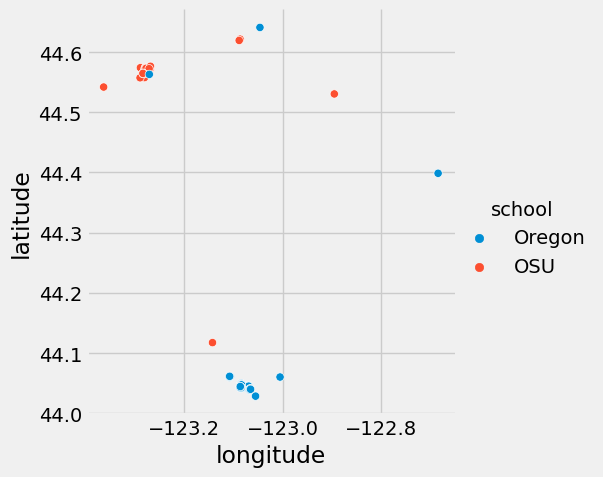

In [73]:
# Just run this cell!
sns.relplot(x = "longitude", y = "latitude", data = coordinates, hue="school")

The locations of the points on this scatter plot might be familiar - run the following cell to see what they correspond to.

In [74]:
# Read in data as a 'datascience' Table. This is because the package has a useful visualization tool for this homework
from datascience import *
coordinates_ds = Table.read_table('coordinates.csv')

# Just run this cell!
colors = {"Oregon":"green", "OSU":"orangered"}
t = Table().with_columns("lat", coordinates_ds.column(0), 
                                      "lon", coordinates_ds.column(1), 
                                      "color", coordinates_ds.apply(colors.get, 2)
                        )
Circle.map_table(t, radius=5, fill_opacity=1)

#### Question 1

Let's begin implementing the k-Nearest Neighbors algorithm. Define the `distance` function, which takes in two arguments: an array of numerical features, and a different array of numerical features. The function should return the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the two arrays. Euclidean distance is often referred to as the straight-line distance formula that you may have learned previously.

For all graded questions, do your work in **numpy** and **pandas**.


<!--
BEGIN QUESTION
name: q1_1
manual: false
-->

In [75]:
def distance(arr1, arr2):
    return np.sqrt(np.sum((arr1 - arr2)**2))

# Don't change/delete the code below in this cell
distance_example = distance(np.array([1, 2, 3]), np.array([4, 5, 6]))
distance_example

5.196152422706632

In [76]:
grader.check("q1_1")

q1_1 results: All test cases passed!

### Splitting the dataset
We'll do 2 different kinds of things with the `coordinates` dataset:
1. We'll build a classifier using coordinates for which we know the associated label; this will teach it to recognize labels of similar coordinate values. This process is known as *training*.
2. We'll evaluate or *test* the accuracy of the classifier we build on data we haven't seen before.

For reasons discussed in lecture and the textbook, we want to use separate datasets for these two purposes.  So we split up our one dataset into two.

#### Question 2

Next, let's split our dataset into a training set and a test set. Let's create a training set with the first 75 rows and a test set with the remaining 25 rows. Remember that assignment to each group should be random, so we should shuffle the table first.

*Hint: as a first step we can shuffle all the rows, then use the* `tbl.take` *function to split up the rows for each table*


<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

In [77]:
coordinates_r = coordinates.sample(frac=1, replace=True)
train = coordinates_r[0:75]
test = coordinates_r[75:]

print("Training set:\t",   train.shape[0], "examples")
print("Test set:\t",       test.shape[0], "examples")
train.head(5), test.head(5)

Training set:	 75 examples
Test set:	 25 examples


(     latitude   longitude  school
 5   44.044160 -123.067910  Oregon
 95  44.564043 -123.281481     OSU
 30  44.045022 -123.068766  Oregon
 50  44.042975 -123.086322  Oregon
 68  44.398620 -122.685490  Oregon,
      latitude   longitude  school
 39  44.040031 -123.064796  Oregon
 75  44.567847 -123.279344     OSU
 97  44.530366 -122.895403     OSU
 12  44.045740 -123.071550  Oregon
 6   44.044100 -123.068290  Oregon)

In [78]:
grader.check("q1_2")

q1_2 results: All test cases passed!

#### Question 3

Assign `features` to an array of the labels of the features from the `coordinates` table.

*Hint: which of the column labels in the `coordinates` table are the features, and which of the column labels correspond to the class we're trying to predict?*

<!--
BEGIN QUESTION
name: q1_3
manual: false
-->

In [79]:
features = np.array(['latitude', 'longitude'])
features

array(['latitude', 'longitude'],
      dtype='<U9')

In [80]:
grader.check("q1_3")

q1_3 results: All test cases passed!

<div class="hide">\pagebreak</div>

#### Question 4

Now define the `classify` function. This function should take in a `row` from a table like `test` and classify it based on the data in `train` using the `k`-Nearest Neighbors based on the correct `features`.

*Hint: be sure that you're converting rows to arrays so that your distance function will work.*

*Hint 2: We've provided some skeleton code that you may find useful, though you're not required to use it*

<!--
BEGIN QUESTION
name: q1_4
manual: false
-->

In [81]:
def classify(row, k, train):
    row = np.array(row)
    row = np.delete(row, -1)
    new_train = train.iloc[:,:-1]

    distances = np.empty(0)

    for train_row in new_train.iloc:
        result = distance(np.array(train_row), row)
        distances = np.append(distances, result)
        
    train_with_distances = train.copy()
    train_with_distances["Distances"] = distances
    nearest_neighbors = train_with_distances.sort_values('Distances', ascending=True).reset_index().iloc[0:k,:]

    most_common_label = nearest_neighbors.groupby('school').count().sort_values('school', ascending=False).index[0]
    return most_common_label

# Don't modify/delete the code below
first_test = classify(test.iloc[0,:], 5, train)
first_test

'Oregon'

In [82]:
grader.check("q1_4")

q1_4 results: All test cases passed!

<div class="hide">\pagebreak</div>

#### Question 5

Now find the `accuracy` of a 3-NN classifier on the `test` set. `accuracy` should be a proportion (not a percentage) of the schools that were correctly predicted.

*Hint: You can do this either with a for loop or by using the `apply` function (specifying axis = 1). If you do the latter, you will need to create another function the calls `classify` and only takes a row as an argument.*

*Note: Usually before using a classifier on a test set, we'd classify first on a "validation" set, which we then can modify our training set again if need be, before actually testing on the test set. You don’t need to do that for this question, but you will learn about this more in DSCI 311.*

<!--
BEGIN QUESTION
name: q1_5
manual: false
-->

In [83]:
predicted = np.empty(0)
test_new = test.iloc[:,:-1] # Remove school from test

for index, row in test_new.iterrows():
    result = classify(row, 3, train)
    predicted = np.append(predicted, result)

count_yes = 0
count_no = 0
for i in np.arange(len(predicted)):
    if predicted[i] == test['school'][i]:
        count_yes += 1
    else:
        count_no += 1



accuracy = count_yes / (count_yes + count_no)
accuracy

KeyError: 0

In [84]:
grader.check("q1_5")

q1_5 results:
    q1_5 - 1 result:
        ❌ Test case failed
        Trying:
            0.85 <= accuracy <= 1
        Expecting:
            True
        **********************************************************************
        Line 3, in q1_5 0
        Failed example:
            0.85 <= accuracy <= 1
        Exception raised:
            Traceback (most recent call last):
              File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\doctest.py", line 1350, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1_5 0[0]>", line 1, in <module>
                0.85 <= accuracy <= 1
            NameError: name 'accuracy' is not defined

#### Question 6

Why do we divide our data into a training and test set? Should we use our test set to find the best possible number of neighbors for a KNN classifer? What is the point of a test set, and why do we only want to use the test set once? Explain. 


<!--
BEGIN QUESTION
name: q1_6
manual: true
-->
<!-- EXPORT TO PDF -->

The purpose of the test set is to make sure that our KNN classifier is accurate. We divide into training and test set because we pull from the same data table as so if our classifier is accurate we will get good results. We only use the test set once because we don't want to have bias towards our classifier.

#### Question 7

Why do we use an odd-numbered `k` in KNN? Consider what could happen when `k` is even. Explain.


<!--
BEGIN QUESTION
name: q1_7
manual: true
-->
<!-- EXPORT TO PDF -->

If k is even, we could have an even split of the most common label, causing there to NOT be a most common label. Using an odd number ensures that does not happen and that there is some form of most common label.

## (OPTIONAL, NOT IN SCOPE): k-NN for Non-Binary Classification

**THIS IS NOT IN SCOPE/IS OPTIONAL**.

In this class, we have taught you how to use the kNN algorithm to classify data as one of two classes. However, much of the data you will encounter in the real world will not fall nicely into one of two categories. 

How can we classify data with non-binary classes? It turns out we can still use kNN! That is, we find the distance between a point and all its neighbors, find the nearest neighbors, and take a majority vote among the neighbors to determine this point's class. 

The only difference is that now the neighboring points have more than two possible classes. This does introduce difficulty because now we have no way of guaranteeing that we will not encounter ties between classes. In the case that we do encounter a tie, we can just arbitrarily choose one of the classes.

In fact, you don't even have to modify the code you wrote before at all to enable multi-class classification!

Let's add some more data to our train table, this time for another class of students, students at Portland State University (PSU).

In [ ]:
new_coordinates = pd.read_csv("new_coordinates.csv")
new_coordinates.value_counts("school")

In [ ]:
classify(new_coordinates.iloc[105,:], 5, new_coordinates)

Our classifier can classify rows as belonging to one of three classes!

Classification is one of the most important fields in statistics, data science, and machine learning. There are thousands of different classification algorithms and modifications of algorithms! There are many that you'll learn if you continue down the path of becoming a data scientist!

You're done with HW 14! Be sure to run the tests and verify that they all pass, then **Save** your changes, then **Download** your file to your host machine (if you are using jupyterhub), then submit your file to the HW14 assignment in **Canvas** by 11:59pm on the due date.